# Module 3: Push Notifications DS

## Import libraries

In [21]:
import os
import boto3
import logging
import numpy as np
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, f1_score, confusion_matrix

logging.basicConfig(
    level=logging.INFO,  # Info level for general information
    format="%(asctime)s - %(levelname)s - %(message)s",
)

## Load dataset

In [22]:
load_dotenv()
AWW_API_KEY = os.getenv("AWW_API_KEY")
AWW_SECRET = os.getenv("AWW_SECRET")

s3 = boto3.client(
    's3',
    aws_access_key_id=AWW_API_KEY,
    aws_secret_access_key=AWW_SECRET
)
bucket_name = 'zrive-ds-data'
prefix = "groceries/box_builder_dataset/"

PROJECT_ROOT = Path().resolve().parent.parent
DATA_DIR = PROJECT_ROOT / "data"
DATA_DIR.mkdir(exist_ok=True)

logging.info(f"Data folder: {DATA_DIR}")

response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

for obj in response.get("Contents", []):
    file_key = obj["Key"]
    if file_key.endswith("/"):  # skip folder placeholders
        continue

    # Strip the first folder ('groceries/') and keep the inner folders
    relative_path = Path(*file_key.split("/")[1:])
    local_path = DATA_DIR / relative_path
    local_path.parent.mkdir(parents=True, exist_ok=True)

    if local_path.exists():
        logging.info(f"Already exists: {local_path}, skipping download.")
    else:
        s3.download_file(bucket_name, file_key, str(local_path))
        logging.info(f"Downloaded {local_path}")

2025-10-21 19:39:49,279 - INFO - Data folder: /Users/maria/Desktop/Zrive DS/zrive-ds/data
2025-10-21 19:39:49,772 - INFO - Already exists: /Users/maria/Desktop/Zrive DS/zrive-ds/data/box_builder_dataset/feature_frame.csv, skipping download.


In [23]:
df = pd.read_csv(DATA_DIR / "box_builder_dataset" / "feature_frame.csv")
df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


## Milestone 1: exploration phase

### Filter to at least 5 items bought

In [24]:
orders_with_5plus = (
    df[df["outcome"] == 1]              # only buy orders
      .groupby("order_id")["variant_id"]
      .nunique()                        # count unique variant_id por order_id
      .loc[lambda x: x >= 5]            # take >= 5 items
      .index                            # get the order_id index
)

df_filtered = df[df["order_id"].isin(orders_with_5plus)]


In [25]:
logging.info(f"Original dataset size: {df.shape[0]} rows")
logging.info(f"Filtered dataset size: {df_filtered.shape[0]} rows")
df_filtered.head()

2025-10-21 19:39:59,479 - INFO - Original dataset size: 2880549 rows
2025-10-21 19:39:59,481 - INFO - Filtered dataset size: 2163953 rows


,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


### Prepare the data

The next step is transforming the categorical features into numericals to train the model. As we have so many categories in `product_type` one-hot encoding would increase the df size a lot, so we have to use a different encoding method. The final idea was to use frequency encoding because other, such as label encoding, create an inexisting order.

In [26]:
df_model = df_filtered.copy()

# Frequency encoding para product_type
freq_map = df_model["product_type"].value_counts(normalize=True)
df_model["product_type"] = df_model["product_type"].map(freq_map)
df_model.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,0.044619,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,0.044619,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,0.044619,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,0.044619,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
5,33826472919172,0.044619,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


Now, we split the data intro train (70%), validation (20%) and test (10%). We have to take into account that our data has a temporal feature, so we split them in time.

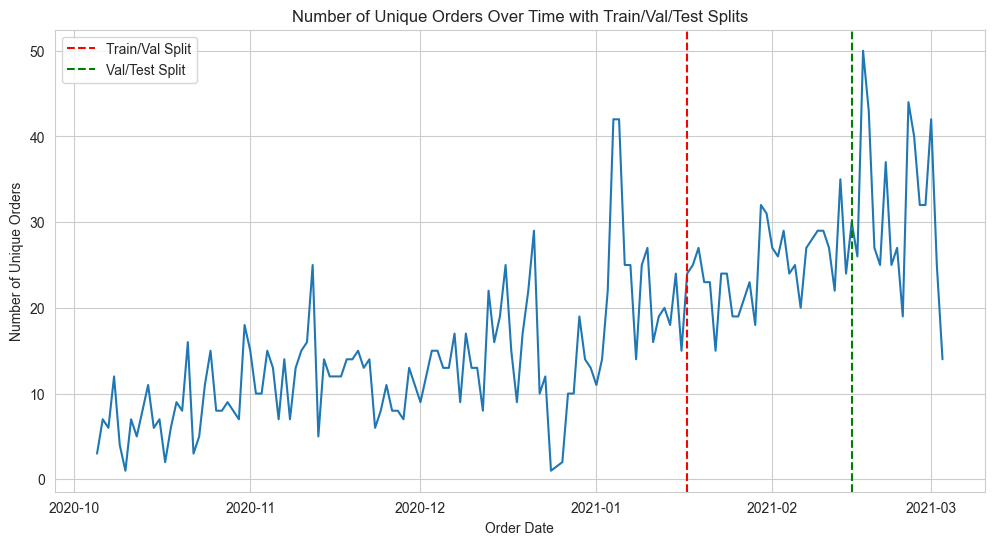

In [27]:
df_model['order_date'] = pd.to_datetime(df_model['order_date'])
orders_per_date = df_model.groupby('order_date')['order_id'].nunique().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=orders_per_date, x='order_date', y='order_id')
train_size = int(0.7 * len(orders_per_date))
val_size = int(0.2 * len(orders_per_date))
train_end_date = orders_per_date['order_date'].iloc[train_size - 1]
val_end_date = orders_per_date['order_date'].iloc[train_size + val_size - 1]
plt.axvline(x=train_end_date, color='r', linestyle='--', label='Train/Val Split')
plt.axvline(x=val_end_date, color='g', linestyle='--', label='Val/Test Split')
plt.legend()
plt.title('Number of Unique Orders Over Time with Train/Val/Test Splits')
plt.xlabel('Order Date')
plt.ylabel('Number of Unique Orders')
plt.show()

In [28]:
def temporal_split_by_order(
    df, 
    date_col, 
    order_col="order_id", 
    feature_cols=None,
    target_col="outcome", 
    train_size=0.7, 
    val_size=0.2, 
    test_size=0.1
):
    """
    Splits a DataFrame into train, validation, and test sets based on order date,
    ensuring no items from the same order appear in multiple splits.
    """
    if not abs(train_size + val_size + test_size - 1.0) < 1e-6:
        raise ValueError("train_size + val_size + test_size must equal 1.0")

    # Order unique orders by date
    orders_sorted = (
        df[[order_col, date_col]]
        .drop_duplicates()
        .sort_values(date_col)
    )

    n_orders = len(orders_sorted)
    train_end = int(train_size * n_orders)
    val_end = int((train_size + val_size) * n_orders)

    # Assign orders to splits
    train_orders = orders_sorted.iloc[:train_end][order_col]
    val_orders = orders_sorted.iloc[train_end:val_end][order_col]
    test_orders = orders_sorted.iloc[val_end:][order_col]

    # Filter DataFrame based on order assignments
    train_df = df[df[order_col].isin(train_orders)]
    val_df = df[df[order_col].isin(val_orders)]
    test_df = df[df[order_col].isin(test_orders)]

    # If feature_cols is specified, select only those columns along with target_col
    if feature_cols is not None:
        train_df = train_df[feature_cols + [target_col]]
        val_df = val_df[feature_cols + [target_col]]
        test_df = test_df[feature_cols + [target_col]]

    # Divide into X and y
    X_train = train_df.drop(columns=[target_col])
    y_train = train_df[target_col]
    X_val = val_df.drop(columns=[target_col])
    y_val = val_df[target_col]
    X_test = test_df.drop(columns=[target_col])
    y_test = test_df[target_col]

    logging.info(f"Total unique orders: {n_orders}")
    logging.info(f"Train orders: {len(train_orders)} ({train_size*100:.1f}%)")
    logging.info(f"Val orders: {len(val_orders)} ({val_size*100:.1f}%)")
    logging.info(f"Test orders: {len(test_orders)} ({test_size*100:.1f}%)")
    logging.info(f"Train rows: {train_df.shape[0]}, Val rows: {val_df.shape[0]}, Test rows: {test_df.shape[0]}")

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = temporal_split_by_order(
    df=df_model,
    date_col="order_date",
    order_col="order_id",
    feature_cols=["product_type", "ordered_before", "abandoned_before", "active_snoozed", "set_as_regular", "global_popularity"],
    target_col="outcome"
)
logging.info(f"Shapes -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

2025-10-21 19:40:01,735 - INFO - Total unique orders: 2603
2025-10-21 19:40:01,736 - INFO - Train orders: 1822 (70.0%)
2025-10-21 19:40:01,737 - INFO - Val orders: 520 (20.0%)
2025-10-21 19:40:01,738 - INFO - Test orders: 261 (10.0%)
2025-10-21 19:40:01,739 - INFO - Train rows: 1446691, Val rows: 466801, Test rows: 250461
2025-10-21 19:40:01,771 - INFO - Shapes -> Train: (1446691, 6), Val: (466801, 6), Test: (250461, 6)


Lastly, we scale the data, which is very important for models like Ridge and Lasso since they penalise high weights.

In [29]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### Linear models

#### OLS

In [30]:
ols = LinearRegression()
ols.fit(X_train_scaled, y_train)

y_val_pred_ols = ols.predict(X_val_scaled)

logging.info(f"OLS F1 Score: {f1_score(y_val, y_val_pred_ols.round()):.4f}")

2025-10-21 19:40:02,816 - INFO - OLS F1 Score: 0.0549


An interesting point is understanding the importance of each feature in the model results.

In [31]:
importance = pd.DataFrame({
    "feature": X_train.columns,
    "coef": ols.coef_.ravel()
}).sort_values("coef", ascending=False)

print(importance)

             feature      coef
2   abandoned_before  0.021121
1     ordered_before  0.019742
5  global_popularity  0.014506
4     set_as_regular  0.005050
0       product_type  0.000550
3     active_snoozed -0.000468


#### Ridge

In [32]:
alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

results = []
for a in alphas:
    model = Ridge(alpha=a)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    auc = roc_auc_score(y_val, y_pred)
    ap = average_precision_score(y_val, y_pred)
    results.append({"alpha": a, "auc": auc, "ap": ap})

results_df = pd.DataFrame(results).sort_values("ap", ascending=False).reset_index(drop=True)
logging.info(f"Ridge tuning results (sorted by AP):\n{results_df}")

best_alpha = results_df.loc[0, "alpha"]
logging.info(f"Selected best alpha: {best_alpha}")

ridge = Ridge(alpha=best_alpha)
ridge.fit(X_train_scaled, y_train)

y_val_pred_r = ridge.predict(X_val_scaled)

logging.info(f"Ridge F1 Score: {f1_score(y_val, y_val_pred_r.round()):.4f}")

2025-10-21 19:40:08,391 - INFO - Ridge tuning results (sorted by AP):
      alpha       auc        ap
0  1000.000  0.839964  0.160456
1   100.000  0.839971  0.160453
2    10.000  0.839971  0.160452
3     0.100  0.839971  0.160451
4     0.010  0.839971  0.160451
5     0.001  0.839971  0.160451
6     1.000  0.839971  0.160451
2025-10-21 19:40:08,392 - INFO - Selected best alpha: 1000.0
2025-10-21 19:40:09,565 - INFO - Ridge F1 Score: 0.0549


In [33]:
importance = pd.DataFrame({
    "feature": X_train.columns,
    "coef": ridge.coef_.ravel()
}).sort_values("coef", ascending=False)

print(importance)

             feature      coef
2   abandoned_before  0.021107
1     ordered_before  0.019729
5  global_popularity  0.014497
4     set_as_regular  0.005049
0       product_type  0.000552
3     active_snoozed -0.000463


#### Lasso

In [34]:
alphas_lasso = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

results = []
for a in alphas_lasso:
    model = Lasso(alpha=a, max_iter=10000)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    auc = roc_auc_score(y_val, y_pred)
    ap = average_precision_score(y_val, y_pred)
    results.append({"alpha": a, "auc": auc, "ap": ap})

results_df = pd.DataFrame(results).sort_values("ap", ascending=False).reset_index(drop=True)
logging.info(f"Lasso tuning results (top 10 by AP):\n{results_df.head(10)}")

best_alpha = results_df.loc[0, "alpha"]
logging.info(f"Selected best alpha for Lasso: {best_alpha}")

# retrain best model and update variables
lasso = Lasso(alpha=best_alpha, max_iter=10000)
lasso.fit(X_train_scaled, y_train)

y_val_pred_lasso = lasso.predict(X_val_scaled)

auc_lasso = roc_auc_score(y_val, y_val_pred_lasso)
ap_lasso = average_precision_score(y_val, y_val_pred_lasso)

logging.info(f"Lasso F1 Score: {f1_score(y_val, y_val_pred_lasso.round()):.4f}")

2025-10-21 19:40:15,025 - INFO - Lasso tuning results (top 10 by AP):
      alpha       auc        ap
0     0.001  0.840367  0.158683
1     0.010  0.833920  0.147983
2     0.100  0.500000  0.013565
3     1.000  0.500000  0.013565
4    10.000  0.500000  0.013565
5   100.000  0.500000  0.013565
6  1000.000  0.500000  0.013565
2025-10-21 19:40:15,026 - INFO - Selected best alpha for Lasso: 0.001
2025-10-21 19:40:16,860 - INFO - Lasso F1 Score: 0.0532


In [35]:
importance = pd.DataFrame({
    "feature": X_train.columns,
    "coef": lasso.coef_.ravel()
}).sort_values("coef", ascending=False)

print(importance)

             feature      coef
2   abandoned_before  0.020210
1     ordered_before  0.018922
5  global_popularity  0.013733
4     set_as_regular  0.004234
0       product_type  0.000000
3     active_snoozed -0.000000


#### Logistic Regression

In [36]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

results_log = []
for C in C_values:
    model = LogisticRegression(C=C, max_iter=1000, class_weight='balanced')
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict_proba(X_val_scaled)[:, 1]
    results_log.append({
        "C": C,
        "auc": roc_auc_score(y_val, y_pred),
        "ap": average_precision_score(y_val, y_pred)
    })

results_log_df = pd.DataFrame(results_log).sort_values("ap", ascending=False).reset_index(drop=True)
logging.info(f"Logistic tuning results (sorted by AP):\n{results_log_df}")

best_C = results_log_df.loc[0, "C"]
logging.info(f"Selected best C: {best_C}")

# retrain best logistic model and update variables
logreg = LogisticRegression(C=best_C, max_iter=1000, class_weight='balanced')
logreg.fit(X_train_scaled, y_train)

y_val_pred_log = logreg.predict_proba(X_val_scaled)[:, 1]

auc_log = roc_auc_score(y_val, y_val_pred_log)
ap_log = average_precision_score(y_val, y_val_pred_log)

logging.info(f"Logistic Regression F1 Score: {f1_score(y_val, y_val_pred_log.round()):.4f}")

2025-10-21 19:40:34,976 - INFO - Logistic tuning results (sorted by AP):
         C       auc        ap
0    0.001  0.837368  0.145631
1    0.010  0.837380  0.145525
2    0.100  0.837384  0.145511
3    1.000  0.837384  0.145509
4   10.000  0.837384  0.145509
5  100.000  0.837384  0.145509
2025-10-21 19:40:34,977 - INFO - Selected best C: 0.001
2025-10-21 19:40:38,557 - INFO - Logistic Regression F1 Score: 0.1204


In [37]:
importance = pd.DataFrame({
    "feature": X_train.columns,
    "coef": lasso.coef_.ravel()
}).sort_values("coef", ascending=False)

print(importance)

             feature      coef
2   abandoned_before  0.020210
1     ordered_before  0.018922
5  global_popularity  0.013733
4     set_as_regular  0.004234
0       product_type  0.000000
3     active_snoozed -0.000000


### Conclusions

Across the four linear models, the F1 scores remain generally low, reflecting the strong class imbalance in the dataset and the models’ tendency to predict the negative class.
- Both OLS and Ridge regression achieved an F1 score of 0.082, indicating that they struggle to correctly identify positive cases.
- Lasso regression performed poorly (F1 = 0.001), as excessive regularization results in almost no positive predictions.
- The Logistic Regression model achieved the best F1 score (0.108), showing a slightly better balance between precision and recall, though still limited by the data imbalance.

#### Confusion matrices

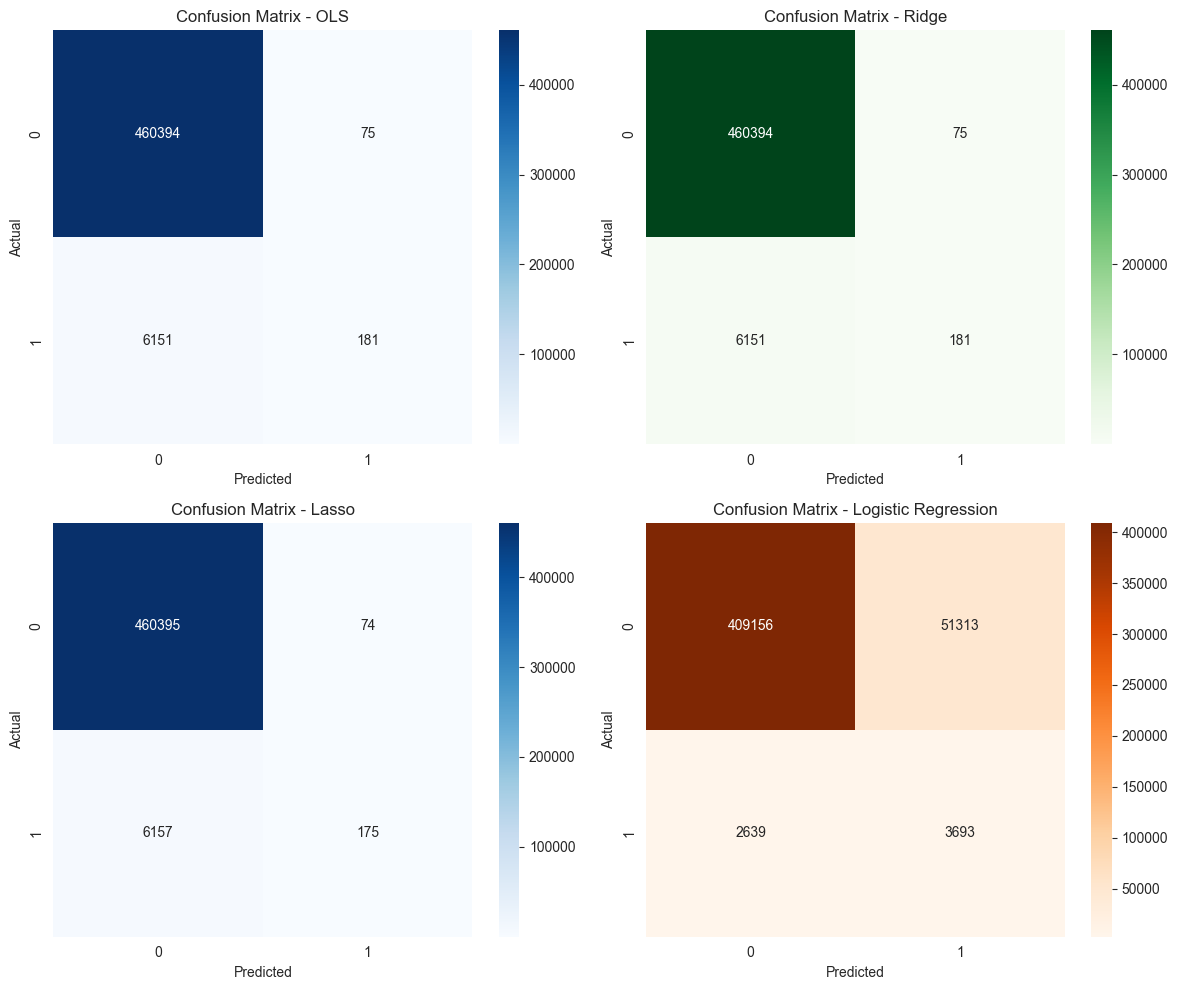

In [38]:
cm_ols = confusion_matrix(y_val, y_val_pred_ols.round())
cm_ridge = confusion_matrix(y_val, y_val_pred_r.round())
cm_lasso = confusion_matrix(y_val, y_val_pred_lasso.round())
cm_log = confusion_matrix(y_val, y_val_pred_log.round())

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.heatmap(cm_ols, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_xlabel('Predicted'); axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_title('Confusion Matrix - OLS')

sns.heatmap(cm_ridge, annot=True, fmt='d', cmap='Greens', ax=axes[0, 1])
axes[0, 1].set_xlabel('Predicted'); axes[0, 1].set_ylabel('Actual')
axes[0, 1].set_title('Confusion Matrix - Ridge')

sns.heatmap(cm_lasso, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_xlabel('Predicted'); axes[1, 0].set_ylabel('Actual')
axes[1, 0].set_title('Confusion Matrix - Lasso')

sns.heatmap(cm_log, annot=True, fmt='d', cmap='Oranges', ax=axes[1, 1])
axes[1, 1].set_xlabel('Predicted'); axes[1, 1].set_ylabel('Actual')
axes[1, 1].set_title('Confusion Matrix - Logistic Regression')

fig.tight_layout()
plt.show()

Looking at the confusion matrices we can see how OLS, Ridge and Lasso tend to predict more 0:
- The first two work in the same way, rarely predict 1 but have higher precision.
- Lasso, however, works in a more conservative way: it hardly ever predicts 1.

On the other side, Logistic Regression detects more 1s but that also means more False Positives.

#### Curves

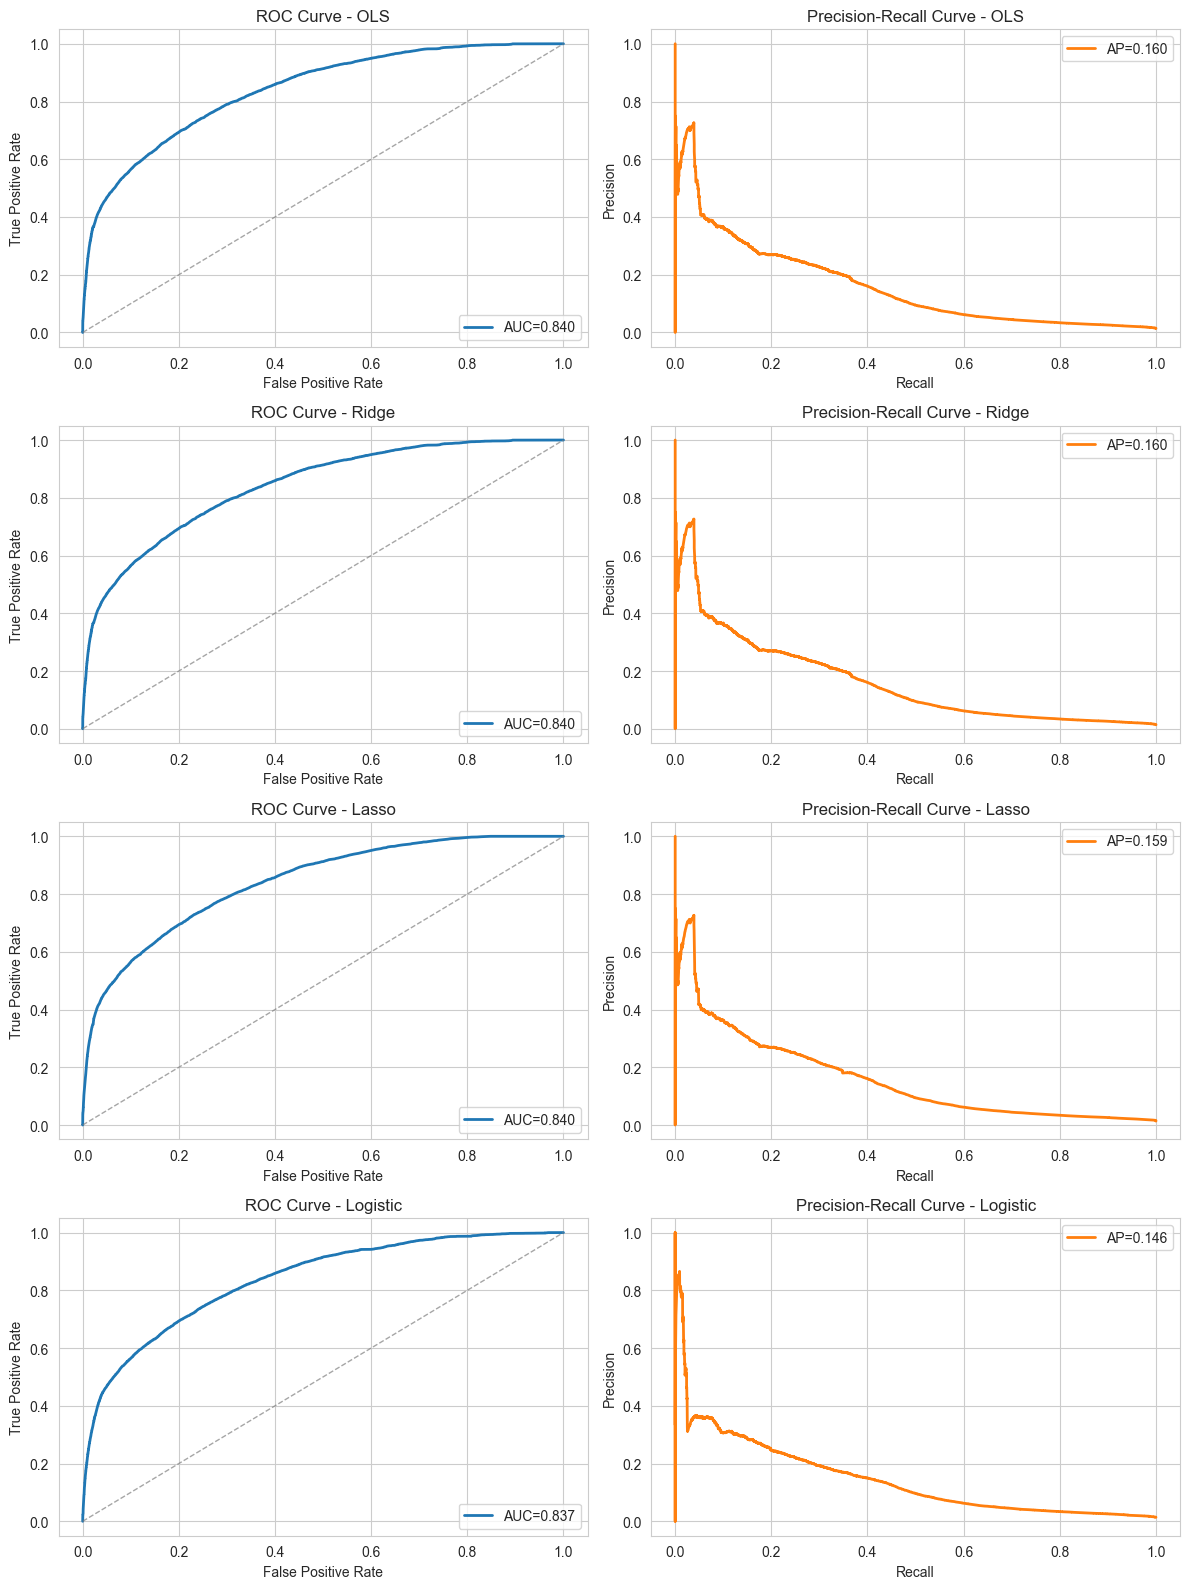

In [39]:
models = [
    ("OLS", y_val_pred_ols),
    ("Ridge", y_val_pred_r),
    ("Lasso", y_val_pred_lasso),
    ("Logistic", y_val_pred_log),
]

sns.set_style("whitegrid")
fig, axs = plt.subplots(len(models), 2, figsize=(12, 4 * len(models)))

for i, (name, y_pred) in enumerate(models):
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    precision, recall, _ = precision_recall_curve(y_val, y_pred)
    auc_ = roc_auc_score(y_val, y_pred)
    ap_ = average_precision_score(y_val, y_pred)

    ax_roc = axs[i, 0]
    ax_pr = axs[i, 1]

    ax_roc.plot(fpr, tpr, color="C0", lw=2, label=f"AUC={auc_:.3f}")
    ax_roc.plot([0, 1], [0, 1], color="grey", lw=1, linestyle="--", alpha=0.7)
    ax_roc.set_xlabel("False Positive Rate")
    ax_roc.set_ylabel("True Positive Rate")
    ax_roc.set_title(f"ROC Curve - {name}")
    ax_roc.legend(loc="lower right")
    ax_roc.grid(True)

    ax_pr.plot(recall, precision, color="C1", lw=2, label=f"AP={ap_:.3f}")
    ax_pr.set_xlabel("Recall")
    ax_pr.set_ylabel("Precision")
    ax_pr.set_title(f"Precision-Recall Curve - {name}")
    ax_pr.legend(loc="upper right")
    ax_pr.grid(True)

fig.tight_layout()
plt.show()


In general, the AUC value is high, which means a good model performance, but the AP value is very low. Since the dataset is imbalanced, we have more `outcome=0` than `outcome = 1`, we get really low precision for True Positives.

#### Model selection

Based on the results, Logistic Regression appears to be the most suitable model. It provides more balanced predictions and was designed for binary classification tasks, unlike the other models, which rely on thresholding to produce class labels.
As a result, Logistic Regression is expected to deliver more reliable performance for predicting whether a user would purchase a product.